# **Данные**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture
from scipy.stats import norm
from scipy.stats import gaussian_kde

In [3]:
data = pd.read_excel('euro_dollar.xlsx')
data = data.sort_values(by = ['curs_euro'])
data.head()

,date,curs_dollar,curs_euro,cum_dollar,cum_euro
3809,2014-12-18,-0.128638,-0.142679,1.232742,1.556321
5605,2022-04-07,-0.079885,-0.084087,1.482782,1.517790
3811,2014-12-20,-0.071521,-0.074047,1.110268,1.406443
5595,2022-03-24,-0.071473,-0.071291,2.151096,2.210241
5638,2022-05-28,-0.051060,-0.070371,1.020191,0.915850


In [4]:
# def remove_outliers(df, columns):
#   for column in columns:
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
#   return df

In [5]:
# data = remove_outliers(data, ['curs_dollar', 'curs_euro'])

In [6]:
list_of_euro = list(data['curs_euro'])
list_of_dollar = list(data['curs_dollar'])
n_samples = data['curs_euro'].size
n_samples

6275

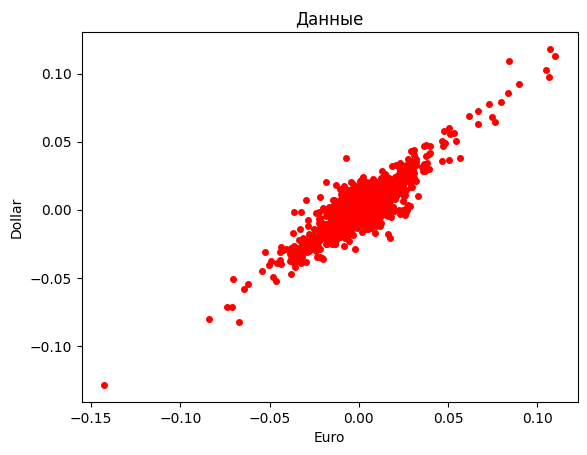

In [7]:
plt.title('Данные')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(data['curs_euro'], data['curs_dollar'], 'ro', markersize=4)
#plt.legend(['С шумом', 'Истинный'])
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
data_z = pd.DataFrame(StandardScaler().fit_transform(data[['curs_dollar', 'curs_euro']]), columns=['curs_dollar', 'curs_euro'])

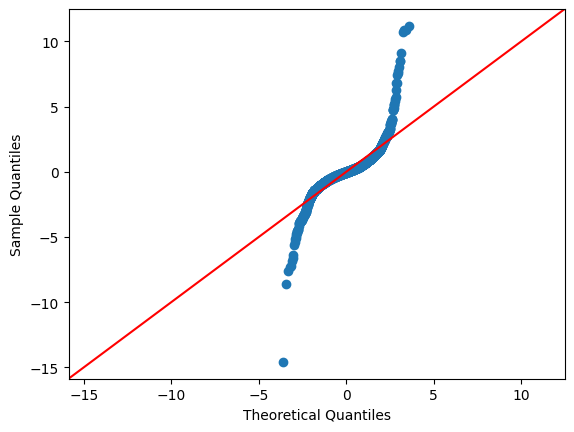

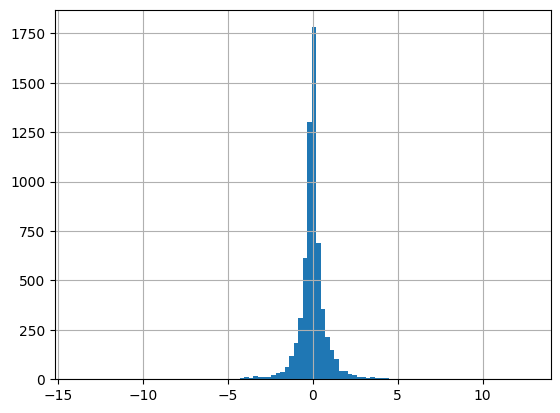

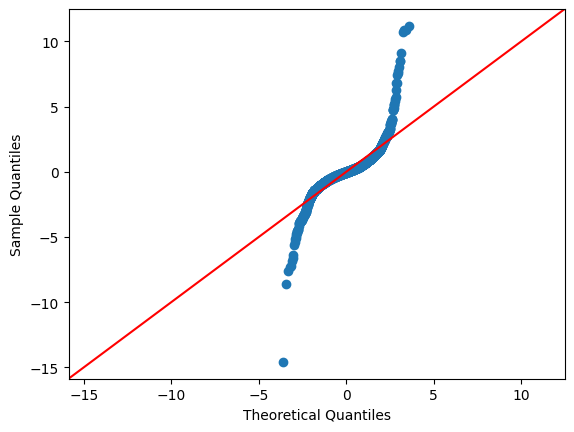

In [9]:
data_z['curs_dollar'].hist(bins=100)
sm.qqplot(data_z['curs_euro'], line ='45')

Таким образом, x рапределён ненормально и правило сильвервмана неприменимо

Попробуем разбить на смесь нормальных распределений

In [10]:
np_data_dollar = np.array(data['curs_dollar']).reshape(-1, 1)
np_data_euro = np.array(data['curs_euro']).reshape(-1, 1)
np_data_euro

array([[-0.14267898],
       [-0.08408749],
       [-0.07404701],
       ...,
       [ 0.10664213],
       [ 0.10718334],
       [ 0.10994489]])

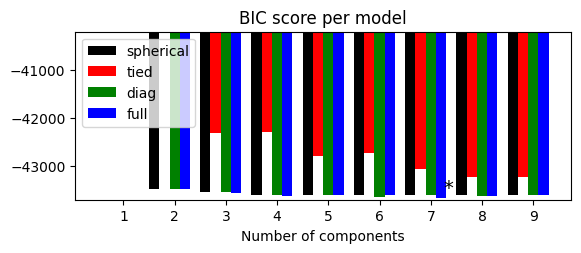

In [10]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(np_data_euro)
        bic.append(gmm.bic(np_data_euro))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'g', 'b', 'c', 'm', 'y'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [11]:
n_components = best_gmm.n_components
best_gmm

GaussianMixture(n_components=7)

In [10]:
a_s = list(range(-1500, 1510))
a_s = np.array(a_s).reshape(-1, 1) / 10000
a_s

array([[-0.15  ],
       [-0.1499],
       [-0.1498],
       ...,
       [ 0.1507],
       [ 0.1508],
       [ 0.1509]])

In [20]:
#X_probas = best_gmm.predict_proba(np_data_euro)
X_probas = best_gmm.predict_proba(a_s)
X_probas

array([[3.95937840e-270, 0.00000000e+000, 2.20704992e-213, ...,
        3.35596753e-095, 4.12070760e-011, 1.00000000e+000],
       [8.74167321e-270, 0.00000000e+000, 4.39717704e-213, ...,
        4.33885812e-095, 4.19744986e-011, 1.00000000e+000],
       [1.92905680e-269, 0.00000000e+000, 8.75644411e-213, ...,
        5.60878839e-095, 4.27560525e-011, 1.00000000e+000],
       ...,
       [2.21924449e-223, 0.00000000e+000, 1.92517018e-259, ...,
        9.65887705e-056, 9.99999534e-001, 4.66472203e-007],
       [1.08198632e-223, 0.00000000e+000, 9.02345248e-260, ...,
        7.95532269e-056, 9.99999537e-001, 4.63151346e-007],
       [5.27257678e-224, 0.00000000e+000, 4.22736757e-260, ...,
        6.55128517e-056, 9.99999540e-001, 4.59855859e-007]])

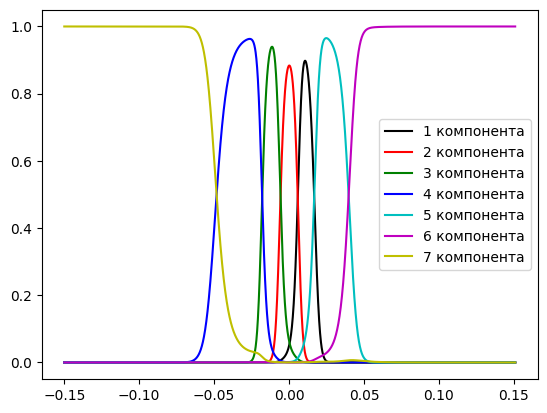

In [21]:
#plt.figure(figsize=(18, 8))
plt.plot(a_s, X_probas[:, 0], color='k', label = '1 компонента')
plt.plot(a_s, X_probas[:, 1], color='r', label = '2 компонента')
plt.plot(a_s, X_probas[:, 2], color='g', label = '3 компонента')
plt.plot(a_s, X_probas[:, 3], color='b', label = '4 компонента')
plt.plot(a_s, X_probas[:, 4], color='c', label = '5 компонента')
plt.plot(a_s, X_probas[:, 5], color='m', label = '6 компонента')
plt.plot(a_s, X_probas[:, 6], color='y', label = '7 компонента')
plt.legend()

# **Непараметрический метод**

## **Расчет с помощью смеси нормальных для каждой точки**

In [18]:
stupid_gmm = mixture.GaussianMixture(n_components=n_samples, covariance_type='diag')
stupid_gmm.fit(np_data_euro)

c:\Users\Dima\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\mixture\_base.py:119: ConvergenceWarning: Number of distinct clusters (6255) found smaller than n_clusters (6275). Possibly due to duplicate points in X.
  .fit(X)


GaussianMixture(covariance_type='diag', n_components=6275)

### **Строим в каждом x_i**

In [19]:
def weight_func (x, a):
  a_component = stupid_gmm.predict(a.reshape(1, -1))
  return stupid_gmm.predict_proba(x)[:, a_component]

n_big_mixture_g = []
# a_s = []
k = 0
for log_inc_euro in np_data_euro:
  k += 1
  # a = a_ / 100
  # a_s.append(a)
  sum_ky = 0
  sum_k = 0
  weight = weight_func(np_data_euro, log_inc_euro)
  sum_k += weight.sum()
  sum_ky += (weight * np_data_dollar).sum()
  n_big_mixture_g.append(sum_ky/sum_k)
  print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [20]:
print(n_big_mixture_g)

[-0.12863817617722503, -0.07988462169390512, -0.07147097224255708, -0.06137211366959102, -0.06137211366959102, -0.08139477291336511, -0.058459145061215474, -0.055970020294887714, -0.04158309590675713, -0.037656336753684794, -0.03945395626240677, -0.04125159760799229, -0.04125159760799229, -0.04103770260440765, -0.04103770260440765, -0.03448669578438429, -0.03448669578438429, -0.03448669578438429, -0.03448669578438429, -0.034301666537802235, -0.030805049939703677, -0.03207643670806679, -0.03203427328060248, -0.03203427328060248, -0.03203427328060248, -0.03167376001136597, -0.0316163583985528, -0.0316163583985528, -0.03154903779914725, -0.03154903779914725, -0.031525186966576024, -0.031525186966576024, -0.031466550196094456, -0.03139933262243978, -0.03139933262243978, -0.03139933262243978, -0.031087848979887492, -0.031087848979887492, -0.0303510383924431, -0.028533698412238573, -0.028025656673419413, -0.028025656673419413, -0.028025656673419413, -0.027619115195940246, -0.0276191151959402

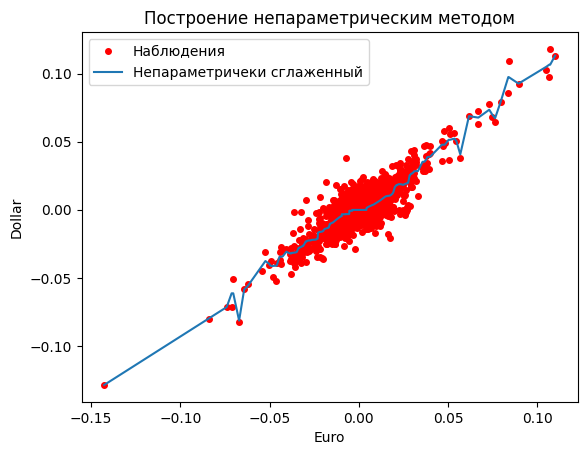

In [ ]:
plt.title('Построение спомощью смеси на точках x')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(data['curs_euro'], data['curs_dollar'], 'ro', markersize=4)
plt.plot(data['curs_euro'], n_big_mixture_g)
plt.legend(['Наблюдения', 'Cглаженный c помощью смеси'])
plt.show()

### **Строим в каждом a (равномерно на отрезке -0.15 до +0.15)**

In [18]:
def weight_func (x, a):
  a_component = stupid_gmm.predict(a.reshape(1, -1))
  return stupid_gmm.predict_proba(x)[:, a_component]

n_big_mixture_g_for_uniform_a = []
a_s = [i / 1000 for i in range(-150, 151)]
for a in a_s:
  print(a)
  sum_ky = 0
  sum_k = 0
  weight = weight_func(np_data_euro, np.array(a))
  sum_k += weight.sum()
  sum_ky += (weight * np_data_dollar).sum()
  n_big_mixture_g_for_uniform_a.append(sum_ky/sum_k)

-0.15


NameError: name 'stupid_gmm' is not defined

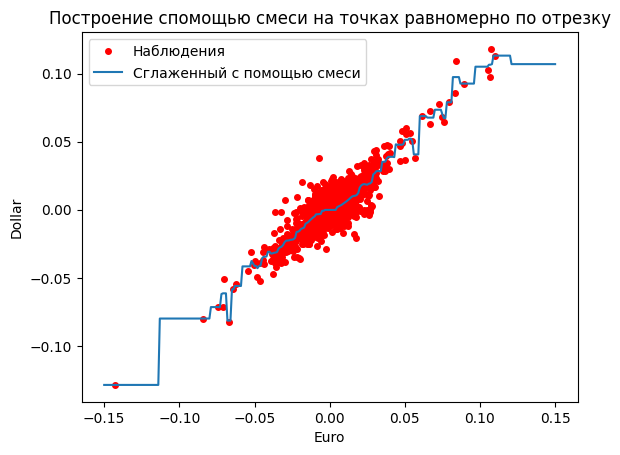

In [23]:
plt.title('Построение спомощью смеси на точках равномерно по отрезку')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(data['curs_euro'], data['curs_dollar'], 'ro', markersize=4)
plt.plot(a_s, n_big_mixture_g_for_uniform_a)
plt.legend(['Наблюдения', 'Сглаженный с помощью смеси'])
plt.show()

## **Расчет с помощью полученной 7 компонентной смеси (модификация метода Станислова-Анатольева)**

### **С использованием только главной компоненты**

#### **Построение на равномерных данных**

In [277]:
def weight_func (x, a, covariances):
  differences = abs(x - np.array(a).reshape(1, -1))
  return norm.sf(differences, 0, covariances)

In [278]:
best_gmm.covariances_

array([[[1.96104558e-05]],

       [[1.08691318e-05]],

       [[2.04549295e-05]],

       [[9.55909016e-05]],

       [[6.34535311e-05]],

       [[7.25713246e-04]],

       [[9.98095246e-04]]])

In [279]:
n_mixture_g = []
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 - 1)
a_s = [i / 1000 for i in range(minimum, maximum)]

components = best_gmm.predict(np_data_euro)
means = best_gmm.means_[components]
covariances = best_gmm.covariances_.reshape(-1, 1)[components] ** 0.5
#covariances = best_gmm.covariances_[0]

for a in a_s:
  print(a)
  weight = weight_func(np_data_euro, np.array(a), covariances)
  sum_k = weight.sum()
  sum_ky = (weight * np_data_dollar).sum()
  n_mixture_g.append(sum_ky/sum_k)

-0.143
-0.142
-0.141
-0.14
-0.139
-0.138
-0.137
-0.136
-0.135
-0.134
-0.133
-0.132
-0.131
-0.13
-0.129
-0.128
-0.127
-0.126
-0.125
-0.124
-0.123
-0.122
-0.121
-0.12
-0.119
-0.118
-0.117
-0.116
-0.115
-0.114
-0.113
-0.112
-0.111
-0.11
-0.109
-0.108
-0.107
-0.106
-0.105
-0.104
-0.103
-0.102
-0.101
-0.1
-0.099
-0.098
-0.097
-0.096
-0.095
-0.094
-0.093
-0.092
-0.091
-0.09
-0.089
-0.088
-0.087
-0.086
-0.085
-0.084
-0.083
-0.082
-0.081
-0.08
-0.079
-0.078
-0.077
-0.076
-0.075
-0.074
-0.073
-0.072
-0.071
-0.07
-0.069
-0.068
-0.067
-0.066
-0.065
-0.064
-0.063
-0.062
-0.061
-0.06
-0.059
-0.058
-0.057
-0.056
-0.055
-0.054
-0.053
-0.052
-0.051
-0.05
-0.049
-0.048
-0.047
-0.046
-0.045
-0.044
-0.043
-0.042
-0.041
-0.04
-0.039
-0.038
-0.037
-0.036
-0.035
-0.034
-0.033
-0.032
-0.031
-0.03
-0.029
-0.028
-0.027
-0.026
-0.025
-0.024
-0.023
-0.022
-0.021
-0.02
-0.019
-0.018
-0.017
-0.016
-0.015
-0.014
-0.013
-0.012
-0.011
-0.01
-0.009
-0.008
-0.007
-0.006
-0.005
-0.004
-0.003
-0.002
-0.001
0.0
0.001
0.00

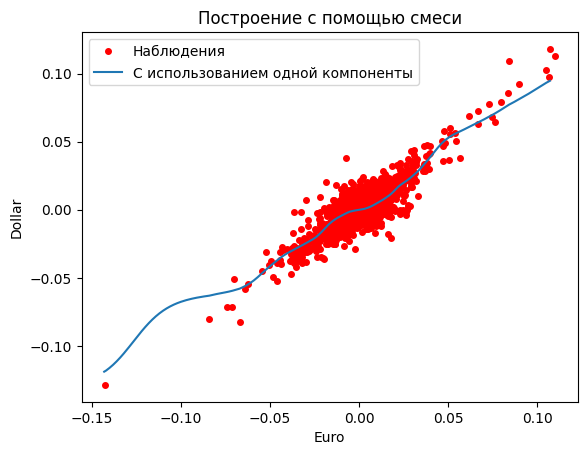

In [280]:
plt.title('Построение с помощью смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, n_mixture_g)
plt.legend(['Наблюдения', 'С использованием одной компоненты'])
plt.show()

#### **Считаем R^2**

In [281]:
n_mixture_g = []
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 - 1)
a_s = [i / 1000 for i in range(minimum, maximum)]

components = best_gmm.predict(np_data_euro)
means = best_gmm.means_[components]
covariances = best_gmm.covariances_.reshape(-1, 1)[components] ** 0.5

for a in np_data_euro:
  #print(a)
  weight = weight_func(np_data_euro, np.array(a), covariances)
  sum_k = weight.sum()
  sum_ky = (weight * np_data_dollar).sum()
  n_mixture_g.append(sum_ky/sum_k)

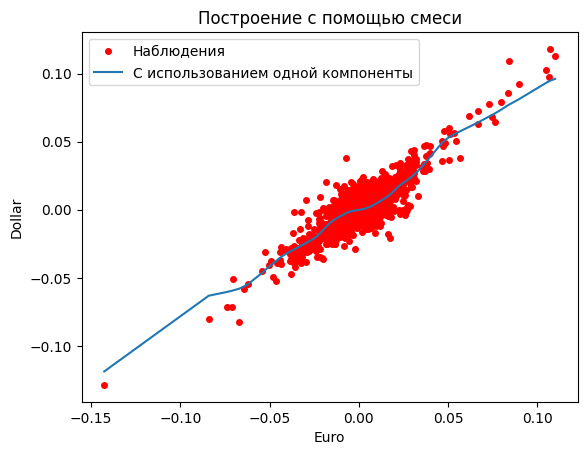

In [282]:
plt.title('Построение с помощью смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(np_data_euro, n_mixture_g)
plt.legend(['Наблюдения', 'С использованием одной компоненты'])
plt.show()

**R^2**

In [283]:
E_Y_X = np.array(n_mixture_g).reshape(-1, 1)

var_Y = np_data_dollar.var(ddof= 1)
var_E_X_Y_gauss = E_Y_X.var(ddof= 1)
R_gauss = var_E_X_Y_gauss / var_Y
R_gauss

0.619890487448363

R^2 с pdf = 0.4955620543288291

R^2 с sf = 0.619890487448363

С sf лучше

**Сравнение частей дисперсии**

In [284]:
var_D_E_Y_X = sum((np_data_dollar - E_Y_X) ** 2) / (n_samples - 1)
var_E_X_Y_gauss + var_D_E_Y_X, var_Y

(array([7.98772206e-05]), 8.635111693713687e-05)

In [285]:
var_D_E_Y_X/var_Y

array([0.30513774])

In [286]:
residiual = np_data_dollar - E_Y_X
covar = np.cov(E_Y_X.flatten(), residiual.flatten())[0][1]
covar

3.2369565031401267e-06

In [287]:
2 * covar / var_Y

0.07497196603714143

In [288]:
2 * covar - (var_Y - var_E_X_Y_gauss - var_D_E_Y_X)

array([1.66777264e-11])

### **С использованием всех компонент**

#### **Построение на равномерных данных**

In [299]:
def weight_func_all (x, a):
  differences = abs(x - np.array(a).reshape(1, -1))
  return norm.pdf(differences, 0, best_gmm.covariances_.reshape(1, -1) ** 0.5) * best_gmm.predict_proba(np_data_euro)

In [300]:
n_mixture_g_all = []
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 1)
a_s = [i / 1000 for i in range(minimum, maximum)]

components = best_gmm.predict(np_data_euro)
means = best_gmm.means_[components]
covariances = best_gmm.covariances_.reshape(-1, 1)[components] ** 0.5

for a in a_s:
  #print(a)
  sum_ky = 0
  sum_k = 0
  weight = weight_func_all(np_data_euro, a)
  sum_k += weight.sum()
  sum_ky += (weight * np_data_dollar).sum()
  n_mixture_g_all.append(sum_ky / sum_k)

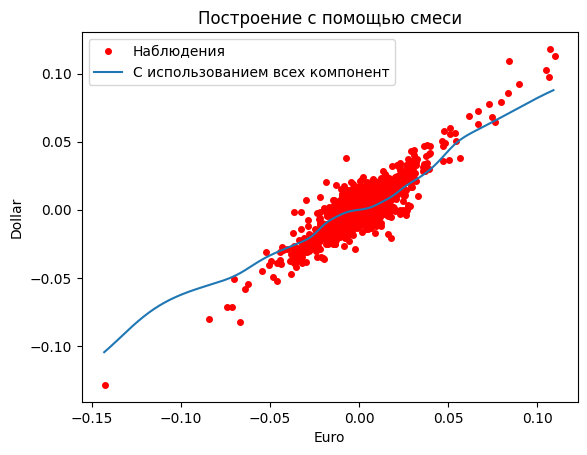

In [301]:
plt.title('Построение с помощью смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, n_mixture_g_all)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

#### **Считаем R^2**

In [302]:
n_mixture_g_all = []
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 1)
a_s = [i / 1000 for i in range(minimum, maximum)]

components = best_gmm.predict(np_data_euro)
means = best_gmm.means_[components]
covariances = best_gmm.covariances_.reshape(-1, 1)[components]

for a in np_data_euro:
  #print(a)
  sum_ky = 0
  sum_k = 0
  weight = weight_func_all(np_data_euro, a)
  sum_k += weight.sum()
  sum_ky += (weight * np_data_dollar).sum()
  n_mixture_g_all.append(sum_ky / sum_k)

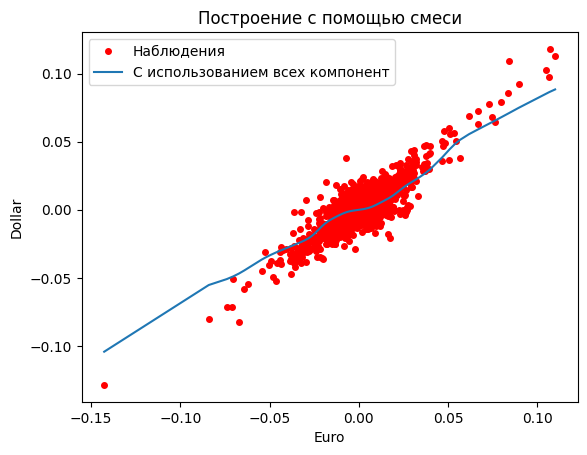

In [303]:
plt.title('Построение с помощью смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(np_data_euro, n_mixture_g_all)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

**R^2**

In [304]:
E_Y_X = np.array(n_mixture_g_all).reshape(-1, 1)

var_Y = np_data_dollar.var(ddof= 1)
var_E_X_Y_gauss = E_Y_X.var(ddof= 1)
R_gauss = var_E_X_Y_gauss / var_Y
R_gauss

0.45086614344283915

R^2 с pdf = 0.45086614344283915

R^2 с sf = 0.5692457985591146

С sf лучше

**Сравнение частей дисперсии**

In [305]:
var_D_E_Y_X = sum((np_data_dollar - E_Y_X) ** 2) / (n_samples - 1)
var_E_X_Y_gauss + var_D_E_Y_X, var_Y

(array([6.75015822e-05]), 8.635111693713687e-05)

In [306]:
residiual = np_data_dollar - E_Y_X
covar = np.cov(E_Y_X.flatten(), residiual.flatten())[0][1]
covar

9.425080746859549e-06

In [307]:
2 * covar - (var_Y - var_E_X_Y_gauss - var_D_E_Y_X)

array([6.26750032e-10])

In [308]:
var_D_E_Y_X/var_Y, 2 * covar/var_Y

(array([0.33084444]), 0.21829667249633736)

## **Расчет с помощью полученной 7 компонентной смеси (оригинальный способ)**

### **С использованием всех компонент на равномерных данных**

In [ ]:
def weight_func_all (x, a, covariances):
  differences = abs(x - np.array(a).reshape(1, -1))
  return norm.pdf(differences, 0, best_gmm.covariances_.reshape(1, -1)) * best_gmm.predict_proba(np_data_euro)

In [1]:
# plt.plot(a_s, norm.pdf(np.array(a_s).reshape(-1, 1), best_gmm.means_.reshape(1, -1), best_gmm.covariances_.reshape(1, -1) ** 0.5)[:, 0])
# plt.plot(a_s, norm.pdf(np.array(a_s).reshape(-1, 1), best_gmm.means_.reshape(1, -1), best_gmm.covariances_.reshape(1, -1) ** 0.5)[:, 1])
# plt.plot(a_s, norm.pdf(np.array(a_s).reshape(-1, 1), best_gmm.means_.reshape(1, -1), best_gmm.covariances_.reshape(1, -1) ** 0.5)[:, 2])
# plt.plot(a_s, norm.pdf(np.array(a_s).reshape(-1, 1), best_gmm.means_.reshape(1, -1), best_gmm.covariances_.reshape(1, -1) ** 0.5)[:, 3])
# plt.plot(a_s, norm.pdf(np.array(a_s).reshape(-1, 1), best_gmm.means_.reshape(1, -1), best_gmm.covariances_.reshape(1, -1) ** 0.5)[:, 4])
# plt.plot(a_s, norm.pdf(np.array(a_s).reshape(-1, 1), best_gmm.means_.reshape(1, -1), best_gmm.covariances_.reshape(1, -1) ** 0.5)[:, 5])
# plt.plot(a_s, norm.pdf(np.array(a_s).reshape(-1, 1), best_gmm.means_.reshape(1, -1), best_gmm.covariances_.reshape(1, -1) ** 0.5)[:, 6])

In [43]:

minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 1)
a_s = np.array([i / 1000 for i in range(minimum, maximum)]).reshape(-1, 1)

X_comp_probas = best_gmm.predict_proba(np_data_euro)
a_s_proba = norm.pdf(a_s, best_gmm.means_.reshape(1, -1), best_gmm.covariances_.reshape(1, -1) ** 0.5)
weights_ky = np.dot(a_s_proba, (X_comp_probas * np_data_dollar).T).sum(axis = 1)
weights_k = np.dot(a_s_proba, X_comp_probas.T).sum(axis = 1)
weights_k += (weights_k == 0) * 10**-11
n_mixture_g_all = weights_ky/weights_k

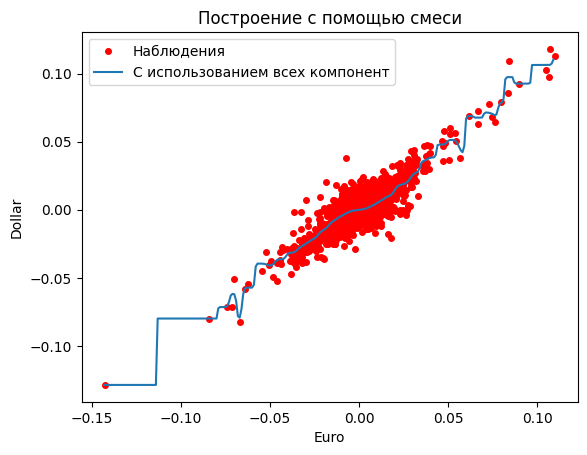

In [44]:
plt.title('Построение с помощью смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, n_mixture_g_all)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

#### **Считаем R^2**

In [45]:
np_data_euro


array([[-0.14267898],
       [-0.08408749],
       [-0.07404701],
       ...,
       [ 0.10664213],
       [ 0.10718334],
       [ 0.10994489]])

In [46]:
X_comp_probas = best_gmm.predict_proba(np_data_euro)
a_s_proba = norm.pdf(np_data_euro, best_gmm.means_.reshape(1, -1), best_gmm.covariances_.reshape(1, -1) ** 0.5)
weights_ky = np.dot(a_s_proba, (X_comp_probas * np_data_dollar).T).sum(axis = 1)
weights_k = np.dot(a_s_proba, X_comp_probas.T).sum(axis = 1)
weights_k += (weights_k == 0) * 10**-11
n_mixture_g_all = weights_ky/weights_k

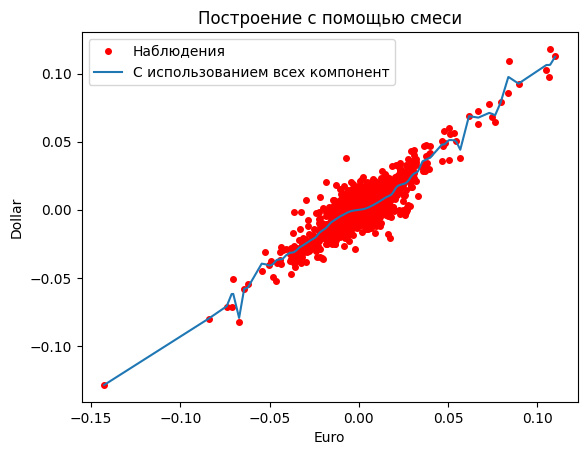

In [47]:
plt.title('Построение с помощью смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(np_data_euro, n_mixture_g_all)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

**R^2**

In [48]:
E_Y_X = np.array(n_mixture_g_all).reshape(-1, 1)

var_Y = np_data_dollar.var(ddof= 1)
var_E_X_Y_gauss = E_Y_X.var(ddof= 1)
R_gauss = var_E_X_Y_gauss / var_Y
R_gauss

0.6819781895551884

**Сравнение частей дисперсии**

In [55]:
var_D_E_Y_X = sum((np_data_dollar - E_Y_X) ** 2) / (n_samples - 1)
var_E_X_Y_gauss + var_D_E_Y_X, var_Y

(array([8.45815607e-05]), 8.635111693713687e-05)

In [56]:
var_D_E_Y_X / var_Y

array([0.29752924])

In [57]:
residiual = np_data_dollar - E_Y_X
covar = np.cov(E_Y_X.flatten(), residiual.flatten())[0][1]
covar

8.847782502351777e-07

In [58]:
2 * covar - (var_Y - var_E_X_Y_gauss - var_D_E_Y_X)

array([2.39563631e-13])

## **Подбор количества компонент**

### **Как считать BIC**

Функция плотности вероятности

1

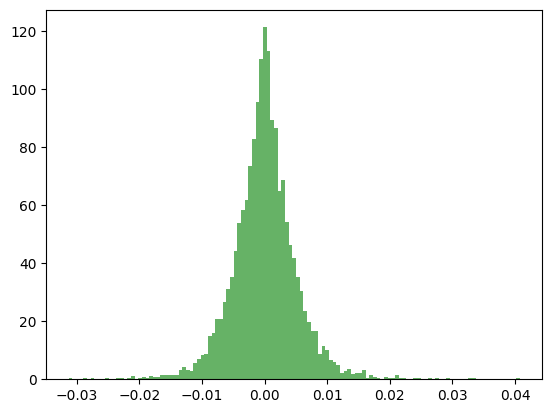

In [13]:
# Построение гистограммы
plt.hist(residiuals, bins='auto', density=True, alpha=0.6, color='g', label='Histogram')
1

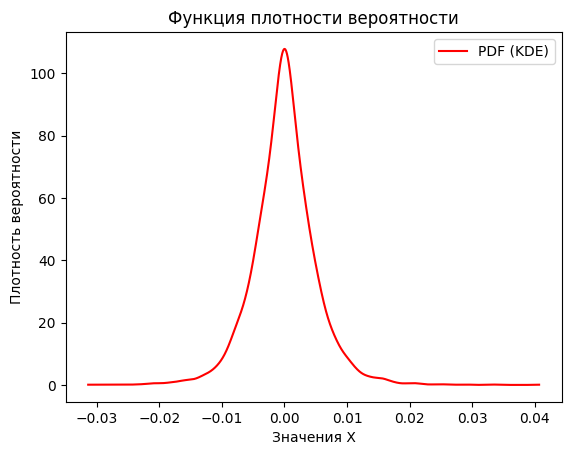

In [24]:

# Построение функции плотности вероятности (PDF) с использованием scipy.stats
density = gaussian_kde(residiuals.T[0])
x_vals = np.linspace(min(residiuals.T[0]), max(residiuals.T[0]), 10000)
plt.plot(x_vals, density(x_vals), color='r', label='PDF (KDE)')

# Настройка графика
plt.title('Функция плотности вероятности')
plt.xlabel('Значения X')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.show()

### **Процесс подбора**

In [69]:
var_Y = np_data_dollar.var(ddof= 1)
max_R_2 = 0
min_cov = 1

min_bic = np.inf
best_bic_R_2 = 0
best_bic_cov = 1

bics = []
R_s = []
covs = []

# cv_types = ['spherical', 'tied', 'diag', 'full']
cv_types = ['full']
n_components_range = range(1, 50)
for n_components in n_components_range:
    print(f"Сейчас обучается модель с {n_components} компонентами")
    cur_R_s = []
    cur_covs = []
    cur_bics = []
    for cv_type in cv_types:
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(np_data_euro)

        X_comp_probas = gmm.predict_proba(np_data_euro)
        X_comp_probas = X_comp_probas * (X_comp_probas > 0.1)
        a_s_proba = norm.pdf(np_data_euro, gmm.means_.reshape(1, -1), gmm.covariances_.reshape(1, -1) ** 0.5)
        weights_ky = np.dot(a_s_proba, (X_comp_probas * np_data_dollar).T).sum(axis = 1)
        weights_k = np.dot(a_s_proba, X_comp_probas.T).sum(axis = 1)
        weights_k += (weights_k == 0) * 10**-11

        E_Y_X = (weights_ky/weights_k).reshape(-1, 1)
        residiuals = np_data_dollar - E_Y_X
        covar = np.cov(E_Y_X.flatten(), residiuals.flatten())[0][1]

        var_E_X_Y = E_Y_X.var(ddof= 1)
        var_resid = sum((residiuals ** 2) / (n_samples - 1))

        density = gaussian_kde(residiuals.T[0])
        LogLikelihood = np.log(density(residiuals.T[0])).sum()

        R_2 = var_E_X_Y / var_Y
        cov_part = 2 * covar / var_Y
        bic = -2 * LogLikelihood + (2 * n_components + n_components - 1) * np.log(n_samples)

        cur_bics.append(bic)
        cur_R_s.append(R_2)
        cur_covs.append(cov_part)

        if cov_part <= 0.05 and R_2 > max_R_2:
            max_R_2 = R_2
            min_cov = cov_part
            best_gmm = gmm

        if bic < min_bic:
            min_bic = bic
            best_gmm_bic = gmm
            best_bic_R_2 = R_2
            best_bic_cov = cov_part
    
    bics.append(cur_bics)
    R_s.append(cur_R_s)
    covs.append(cur_covs)


Сейчас обучается модель с 1 компонентами
Сейчас обучается модель с 2 компонентами
Сейчас обучается модель с 3 компонентами
Сейчас обучается модель с 4 компонентами
Сейчас обучается модель с 5 компонентами
Сейчас обучается модель с 6 компонентами
Сейчас обучается модель с 7 компонентами
Сейчас обучается модель с 8 компонентами
Сейчас обучается модель с 9 компонентами
Сейчас обучается модель с 10 компонентами
Сейчас обучается модель с 11 компонентами
Сейчас обучается модель с 12 компонентами
Сейчас обучается модель с 13 компонентами
Сейчас обучается модель с 14 компонентами
Сейчас обучается модель с 15 компонентами
Сейчас обучается модель с 16 компонентами
Сейчас обучается модель с 17 компонентами
Сейчас обучается модель с 18 компонентами
Сейчас обучается модель с 19 компонентами
Сейчас обучается модель с 20 компонентами
Сейчас обучается модель с 21 компонентами
Сейчас обучается модель с 22 компонентами
Сейчас обучается модель с 23 компонентами
Сейчас обучается модель с 24 компонентами
С

In [70]:
R_S = np.array(R_s)
COVS = np.array(covs)
BICS = np.array(bics)

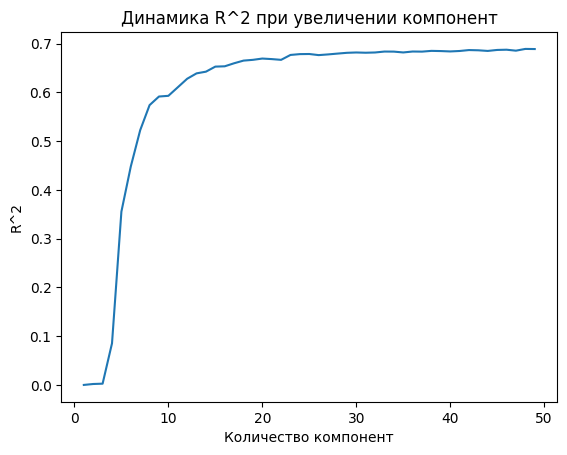

In [71]:
plt.title('Динамика R^2 при увеличении компонент')
plt.xlabel('Количество компонент')
plt.ylabel('R^2')
plt.plot(n_components_range, R_S[:, 0])
plt.show()

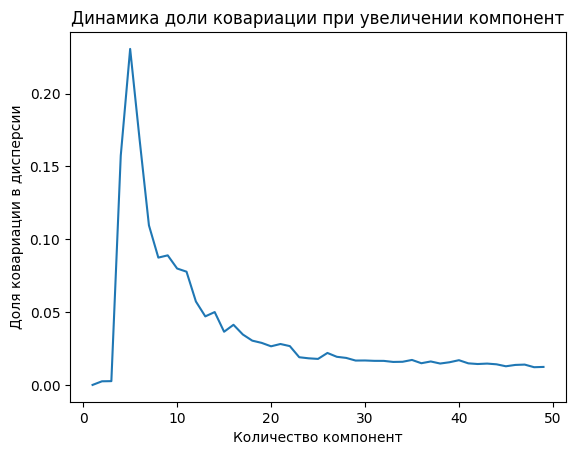

In [72]:
plt.title('Динамика доли ковариации при увеличении компонент')
plt.xlabel('Количество компонент')
plt.ylabel('Доля ковариации в дисперсии')
plt.plot(n_components_range, COVS[:, 0])
plt.show()

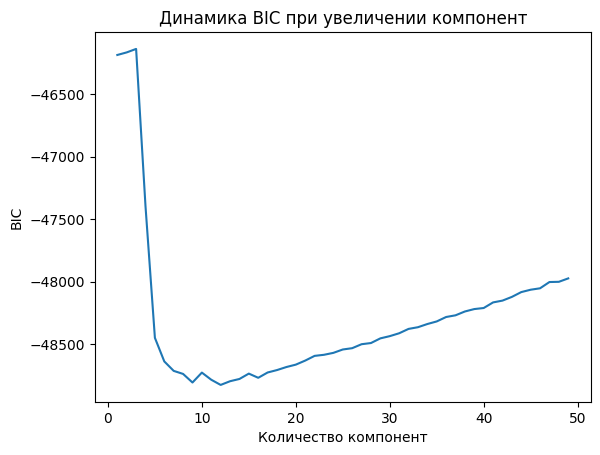

In [73]:
plt.title('Динамика BIC при увеличении компонент')
plt.xlabel('Количество компонент')
plt.ylabel('BIC')
plt.plot(n_components_range, BICS[:, 0])
plt.show()

In [74]:
print(f"Лучший R^2: {max_R_2}")
print(f"Соответствующая доля ковариации: {min_cov}")
best_gmm

Лучший R^2: 0.6890902480253009
Соответствующая доля ковариации: 0.012162619272771624


GaussianMixture(n_components=48)

In [75]:
print(f"Лучший BIC: {min_bic}")
print(f"Соответствующий R^2: {best_bic_R_2}")
print(f"Соответствующая доля ковариации: {best_bic_cov}")
best_gmm_bic

Лучший BIC: -48826.0685948075
Соответствующий R^2: 0.6278889702548365
Соответствующая доля ковариации: 0.05727337535716184


GaussianMixture(n_components=12)

In [76]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 1)
a_s = np.array([i / 1000 for i in range(minimum, maximum)]).reshape(-1, 1)

X_comp_probas = best_gmm_bic.predict_proba(np_data_euro)
a_s_proba = norm.pdf(a_s, best_gmm_bic.means_.reshape(1, -1), best_gmm_bic.covariances_.reshape(1, -1) ** 0.5)
weights_ky = np.dot(a_s_proba, (X_comp_probas * np_data_dollar).T).sum(axis = 1)
weights_k = np.dot(a_s_proba, X_comp_probas.T).sum(axis = 1)
weights_k += (weights_k == 0) * 10**-11
n_mixture_g_all = weights_ky/weights_k

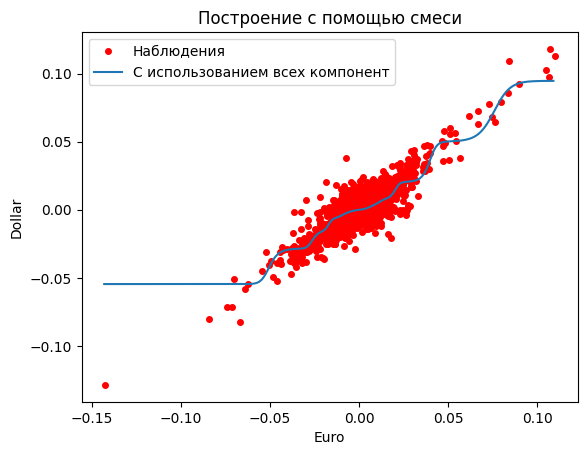

In [77]:
plt.title('Построение с помощью смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, n_mixture_g_all)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

## **Разбираемся с выбросами**

### **Выброс как точка в хвосте покомпонентно**

In [78]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 1)
a_s = np.array([i / 1000 for i in range(minimum, maximum)]).reshape(-1, 1)

X_comp_probas = best_gmm_bic.predict_proba(np_data_euro)
X_comp_probas_without_errors = X_comp_probas * (X_comp_probas > 0.1)
a_s_proba = norm.pdf(a_s, best_gmm_bic.means_.reshape(1, -1), best_gmm_bic.covariances_.reshape(1, -1) ** 0.5)
weights_ky = np.dot(a_s_proba, (X_comp_probas_without_errors * np_data_dollar).T).sum(axis = 1)
weights_k = np.dot(a_s_proba, X_comp_probas_without_errors.T).sum(axis = 1)
weights_k += (weights_k == 0) * 10**-11
n_mixture_g_all_without_errors = weights_ky/weights_k

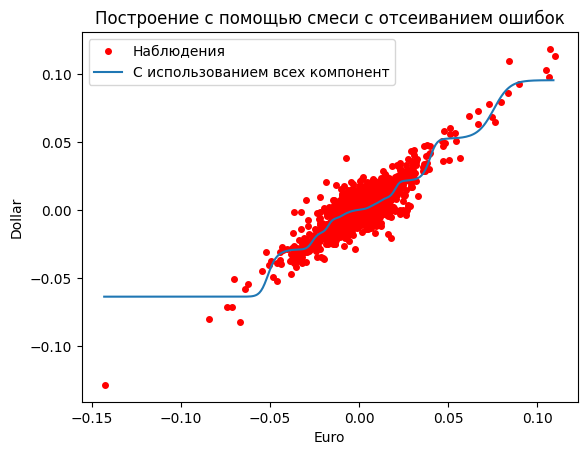

In [79]:
plt.title('Построение с помощью смеси с отсеиванием ошибок')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, n_mixture_g_all_without_errors)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

In [80]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 1)
a_s = np.array([i / 1000 for i in range(minimum, maximum)]).reshape(-1, 1)

X_comp_probas = best_gmm_bic.predict_proba(np_data_euro)
X_comp_probas_without_errors = X_comp_probas * (X_comp_probas > 0.1)
a_s_proba = norm.pdf(np_data_euro, best_gmm_bic.means_.reshape(1, -1), best_gmm_bic.covariances_.reshape(1, -1) ** 0.5)
weights_ky = np.dot(a_s_proba, (X_comp_probas_without_errors * np_data_dollar).T).sum(axis = 1)
weights_k = np.dot(a_s_proba, X_comp_probas_without_errors.T).sum(axis = 1)
weights_k += (weights_k == 0) * 10**-11
n_mixture_g_all_without_errors = weights_ky/weights_k

In [81]:
E_Y_X = (weights_ky/weights_k).reshape(-1, 1)
residiuals = np_data_dollar - E_Y_X
covar = np.cov(E_Y_X.flatten(), residiuals.flatten())[0][1]

var_E_X_Y = E_Y_X.var(ddof= 1)
var_resid = sum((residiuals ** 2) / (n_samples - 1))

density = gaussian_kde(residiuals.T[0])
LogLikelihood = np.log(density(residiuals.T[0])).sum()

R_2__we = var_E_X_Y / var_Y
cov_part_we = 2 * covar / var_Y
bic_we = -2 * LogLikelihood + (2 * 12 + 12 - 1) * np.log(n_samples)

**Стало**

In [82]:
print(f"BIC после коррекции: {bic_we}")
print(f"Полученный R^2: {R_2__we}")
print(f"Соответствующая доля ковариации: {cov_part_we}")

BIC после коррекции: -48826.0685948075
Полученный R^2: 0.6278889702548365
Соответствующая доля ковариации: 0.05727337535716184


**Было**

In [83]:
print(f"Лучший BIC: {min_bic}")
print(f"Соответствующий R^2: {best_bic_R_2}")
print(f"Соответствующая доля ковариации: {best_bic_cov}")

Лучший BIC: -48826.0685948075
Соответствующий R^2: 0.6278889702548365
Соответствующая доля ковариации: 0.05727337535716184


## **Расчет с простым гауссовским ядром и общим окном**

### **Расчет по правилу Сильвермана**

In [11]:
var_X = data['curs_euro'].var(ddof= 1) ** 0.5
h = 1.06 * var_X * (n_samples ** (-0.2))
h

0.0018078473823631125

In [39]:
# h = 0.0005

In [14]:

def K_h (x, h):
  e = np.exp(-((x/h) ** 2) / 2)
  return (1 / (2 * np.pi) ** 0.5) * e / h

np_g = []
a_s = [i / 1000 for i in range(-150, 151)]
for a in np_data_euro:
  sum_ky = 0
  sum_k = 0
  k_h = K_h(data['curs_euro'] - a, h)
  sum_k += sum(k_h)
  sum_ky += sum(k_h * data['curs_dollar'])
  np_g.append(sum_ky/sum_k)



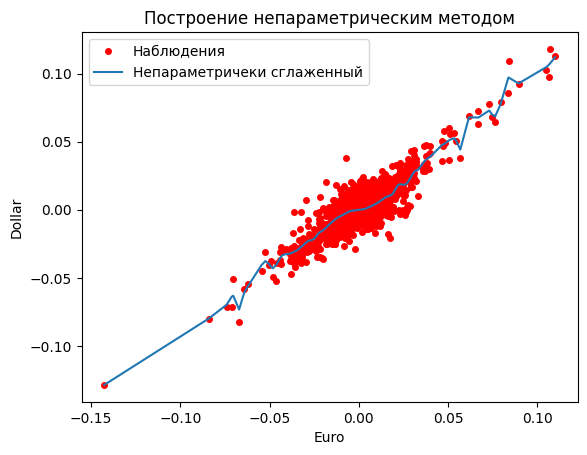

In [86]:
plt.title('Построение непараметрическим методом')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(data['curs_euro'], data['curs_dollar'], 'ro', markersize=4)
plt.plot(np_data_euro, np_g)
plt.legend(['Наблюдения', 'Непараметричеки сглаженный'])
plt.show()

**R^2**

In [88]:
E_Y_X = np.array(np_g).reshape(-1, 1)

var_Y = np_data_dollar.var(ddof= 1)
var_E_X_Y_gauss = E_Y_X.var(ddof= 1)
R_gauss = var_E_X_Y_gauss / var_Y
R_gauss

0.677489653464059

**Сравнение частей дисперсии**

In [89]:
var_D_E_Y_X/var_Y

array([0.29638496])

In [90]:
residiual = np_data_dollar - E_Y_X
covar = np.cov(E_Y_X.flatten(), residiual.flatten())[0][1]
2 * covar / var_Y

0.02612573642059561

**Считаем BIC, R^2 и долю ковариации**

In [91]:
E_Y_X = np.array(np_g).reshape(-1, 1)
residiuals = np_data_dollar - E_Y_X
covar = np.cov(E_Y_X.flatten(), residiuals.flatten())[0][1]

var_E_X_Y = E_Y_X.var(ddof= 1)
var_resid = sum((residiuals ** 2) / (n_samples - 1))

density = gaussian_kde(residiuals.T[0])
LogLikelihood = np.log(density(residiuals.T[0])).sum()

R_2 = var_E_X_Y / var_Y
cov_part = 2 * covar / var_Y
bic_3 = -2 * LogLikelihood + 3 * np.log(n_samples)
bic_1 = -2 * LogLikelihood + np.log(n_samples)

In [92]:
print(f'Полученный R^2: {R_2}')
print(f'Полученная доля ковариации: {cov_part}')
print(f'BIC, если считать 1 оцениваемый параметр: {bic_1}')
print(f'BIC, если считать 3 оцениваемых параметра: {bic_3}')

Полученный R^2: 0.677489653464059
Полученная доля ковариации: 0.02612573642059561
BIC, если считать 1 оцениваемый параметр: -49306.60773705846
BIC, если считать 3 оцениваемых параметра: -49289.11907953046


**Сравнение с нашим методом**

In [93]:
print(f"Лучший BIC: {min_bic}")
print(f"Соответствующий R^2: {R_2__we}")
print(f"Соответствующая доля ковариации: {cov_part_we}")

Лучший BIC: -48826.0685948075
Соответствующий R^2: 0.6278889702548365
Соответствующая доля ковариации: 0.05727337535716184


### **Подбор окна по BIC**

In [24]:
def K_h (x, h):
  e = np.exp(-((x/h) ** 2) / 2)
  return (1 / (2 * np.pi) ** 0.5) * e / h

In [40]:
h

0.0018078473823631125

In [21]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 10)
a_s = np.array([i / 1000 for i in range(minimum, maximum)])

In [ ]:
np_data_euro.reshape((n_samples))

(6275,)

In [ ]:
k_h = K_h(np_data_euro - a_s, h)
E_Y_X = (k_h * np_data_dollar).sum(axis = 0) / k_h.sum(axis = 0)

(262,)

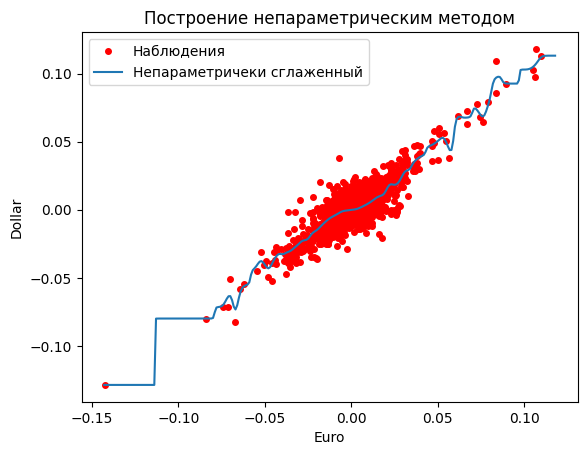

In [39]:
plt.title('Построение непараметрическим методом')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, E_Y_X)
plt.legend(['Наблюдения', 'Непараметричеки сглаженный'])
plt.show()

In [52]:
var_Y = np_data_dollar.var(ddof= 1)
max_R_2 = 0
min_cov = 1

min_bic = np.inf
best_bic_R_2 = 0
best_bic_cov = 1

bics = []
R_s = []
covs = []

h_s = [i / 100000 for i in range(50, 500)]
for h in h_s:
    print(f"Сейчас обучается модель с шириной окна {h}")

    k_h = K_h(np_data_euro - np_data_euro.reshape((n_samples)), h)
    res = (k_h * np_data_dollar).sum(axis = 0) / k_h.sum(axis = 0)

    E_Y_X = res.reshape(-1, 1)
    residiuals = np_data_dollar - E_Y_X
    covar = np.cov(E_Y_X.flatten(), residiuals.flatten())[0][1]

    var_E_X_Y = E_Y_X.var(ddof= 1)
    var_resid = sum((residiuals ** 2) / (n_samples - 1))

    density = gaussian_kde(residiuals.T[0])
    LogLikelihood = np.log(density(residiuals.T[0])).sum()

    R_2 = var_E_X_Y / var_Y
    cov_part = 2 * covar / var_Y
    bic = -2 * LogLikelihood + 3 * np.log(n_samples)

    bics.append(bic)
    R_s.append(R_2)
    covs.append(cov_part)

    if cov_part <= 0.05 and R_2 > max_R_2:
        max_R_2 = R_2
        min_cov = cov_part
        best_h = h

    if bic < min_bic:
        min_bic = bic
        best_h_bic = h
        best_bic_R_2 = R_2
        best_bic_cov = cov_part

Сейчас обучается модель с шириной окна 0.0005
Сейчас обучается модель с шириной окна 0.00051
Сейчас обучается модель с шириной окна 0.00052
Сейчас обучается модель с шириной окна 0.00053
Сейчас обучается модель с шириной окна 0.00054
Сейчас обучается модель с шириной окна 0.00055
Сейчас обучается модель с шириной окна 0.00056
Сейчас обучается модель с шириной окна 0.00057
Сейчас обучается модель с шириной окна 0.00058
Сейчас обучается модель с шириной окна 0.00059
Сейчас обучается модель с шириной окна 0.0006
Сейчас обучается модель с шириной окна 0.00061
Сейчас обучается модель с шириной окна 0.00062
Сейчас обучается модель с шириной окна 0.00063
Сейчас обучается модель с шириной окна 0.00064
Сейчас обучается модель с шириной окна 0.00065
Сейчас обучается модель с шириной окна 0.00066
Сейчас обучается модель с шириной окна 0.00067
Сейчас обучается модель с шириной окна 0.00068
Сейчас обучается модель с шириной окна 0.00069
Сейчас обучается модель с шириной окна 0.0007
Сейчас обучается

In [53]:
R_S = np.array(R_s)
COVS = np.array(covs)
BICS = np.array(bics)

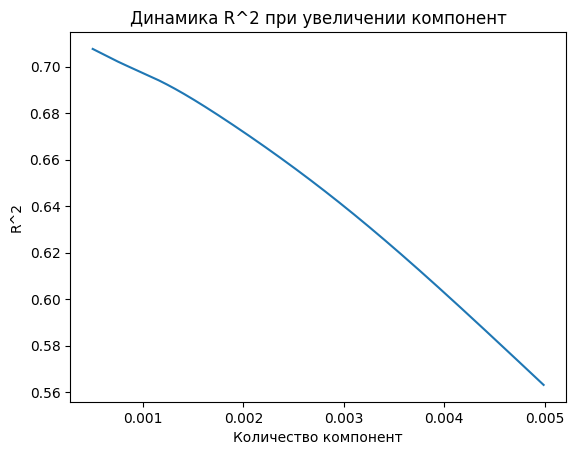

In [54]:
plt.title('Динамика R^2 при увеличении компонент')
plt.xlabel('Количество компонент')
plt.ylabel('R^2')
plt.plot(h_s, R_S)
plt.show()

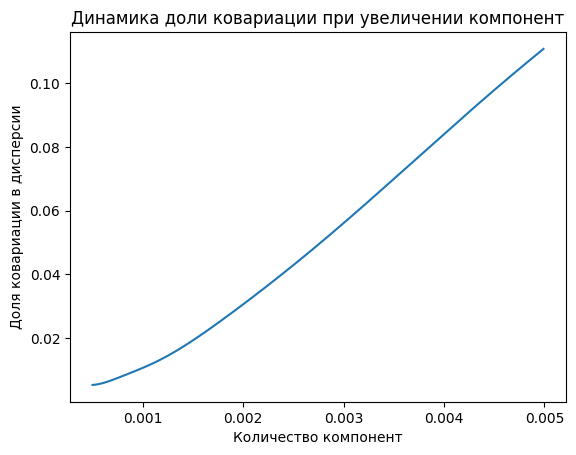

In [55]:
plt.title('Динамика доли ковариации при увеличении компонент')
plt.xlabel('Количество компонент')
plt.ylabel('Доля ковариации в дисперсии')
plt.plot(h_s, COVS)
plt.show()

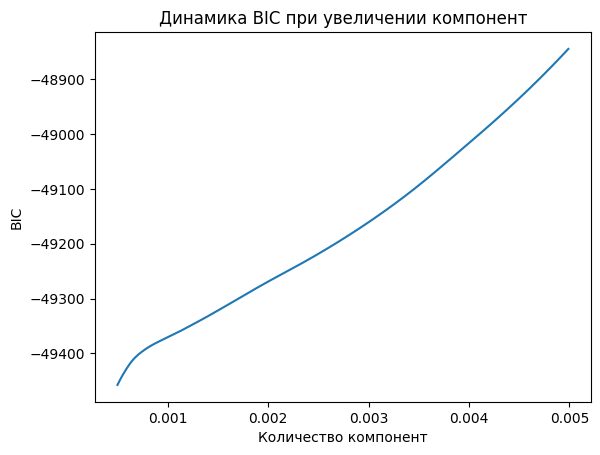

In [56]:
plt.title('Динамика BIC при увеличении компонент')
plt.xlabel('Количество компонент')
plt.ylabel('BIC')
plt.plot(h_s, BICS)
plt.show()

In [ ]:
print(f"Лучший R^2: {max_R_2}")
print(f"Соответствующая доля ковариации: {min_cov}")
best_gmm

Лучший R^2: 0.6890902480253009
Соответствующая доля ковариации: 0.012162619272771624


GaussianMixture(n_components=48)

In [ ]:
print(f"Лучший BIC: {min_bic}")
print(f"Соответствующий R^2: {best_bic_R_2}")
print(f"Соответствующая доля ковариации: {best_bic_cov}")
best_gmm_bic

Лучший BIC: -48826.0685948075
Соответствующий R^2: 0.6278889702548365
Соответствующая доля ковариации: 0.05727337535716184


GaussianMixture(n_components=12)

In [ ]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 1)
a_s = np.array([i / 1000 for i in range(minimum, maximum)]).reshape(-1, 1)

X_comp_probas = best_gmm_bic.predict_proba(np_data_euro)
a_s_proba = norm.pdf(a_s, best_gmm_bic.means_.reshape(1, -1), best_gmm_bic.covariances_.reshape(1, -1) ** 0.5)
weights_ky = np.dot(a_s_proba, (X_comp_probas * np_data_dollar).T).sum(axis = 1)
weights_k = np.dot(a_s_proba, X_comp_probas.T).sum(axis = 1)
weights_k += (weights_k == 0) * 10**-11
n_mixture_g_all = weights_ky/weights_k

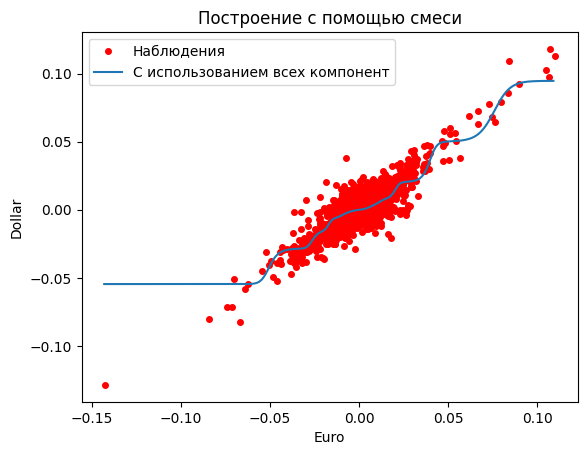

In [ ]:
plt.title('Построение с помощью смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, n_mixture_g_all)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

## **Расчет с простым гауссовским ядром и оптимизированным кросс-валидацией по средней ошибке окном**

In [16]:
differences = []
for i in range(n_samples):
    print(i)
    lane = []
    for j in range(n_samples):
      lane.append((np_data_euro[j] - np_data_euro[i])[0])
    differences.append(lane)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [17]:
np_differences = np.array(differences)
np_differences

array([[ 0.        ,  0.05859149,  0.06863197, ...,  0.24932111,
         0.24986232,  0.25262388],
       [-0.05859149,  0.        ,  0.01004048, ...,  0.19072962,
         0.19127083,  0.19403239],
       [-0.06863197, -0.01004048,  0.        , ...,  0.18068914,
         0.18123035,  0.1839919 ],
       ...,
       [-0.24932111, -0.19072962, -0.18068914, ...,  0.        ,
         0.00054121,  0.00330276],
       [-0.24986232, -0.19127083, -0.18123035, ..., -0.00054121,
         0.        ,  0.00276155],
       [-0.25262388, -0.19403239, -0.1839919 , ..., -0.00330276,
        -0.00276155,  0.        ]])

In [18]:
h = 0.01

In [21]:
all_k = K_h(np_differences, h)

In [22]:
np.fill_diagonal(all_k, 0)

In [23]:
all_k

array([[0.00000000e+000, 1.40063972e-006, 2.35787284e-009, ...,
        4.16845857e-134, 1.07975582e-134, 1.04736463e-137],
       [1.40063972e-006, 0.00000000e+000, 2.40991179e+001, ...,
        4.05082920e-078, 1.44081984e-078, 7.04832451e-081],
       [2.35787284e-009, 2.40991179e+001, 0.00000000e+000, ...,
        5.07516180e-070, 1.90596611e-070, 1.23029612e-072],
       ...,
       [4.16845857e-134, 4.05082920e-078, 5.07516180e-070, ...,
        0.00000000e+000, 3.98358444e+001, 3.77766227e+001],
       [1.07975582e-134, 1.44081984e-078, 1.90596611e-070, ...,
        3.98358444e+001, 0.00000000e+000, 3.84016627e+001],
       [1.04736463e-137, 7.04832451e-081, 1.23029612e-072, ...,
        3.77766227e+001, 3.84016627e+001, 0.00000000e+000]])

In [37]:
new = (all_k * np_data_dollar).sum(axis = 0)/all_k.sum(axis = 0)
new

array([-0.07986488, -0.06647228, -0.06373201, ...,  0.10904702,
        0.10302918,  0.10534047])

In [62]:
def K_h (x, h):
  e = np.exp(-((x/h) ** 2) / 2)
  return (1 / (2 * np.pi) ** 0.5) * e / h

def g_calculation(np_differences, h):
  np_g_cross_val = []
  all_k = K_h(np_differences, h)
  np.fill_diagonal(all_k, 0)
  np_g_cross_val = (all_k * np_data_dollar).sum(axis = 0)/all_k.sum(axis = 0)
  return np_g_cross_val

In [74]:
def CV(h):
  np_g_cross_val = np.array(g_calculation(np_differences, h)).reshape(-1, 1)
  return (1 / n_samples) * (((np_data_dollar - np_g_cross_val) ** 2).sum())

In [44]:
a = g_calculation(np_differences, 0.01)

In [75]:
from scipy.optimize import minimize
optimal_h = minimize(CV, 0.002).x[0]

In [76]:
optimal_h

0.0017321346403785167

In [77]:
CV(optimal_h)

2.6943946989979885e-05

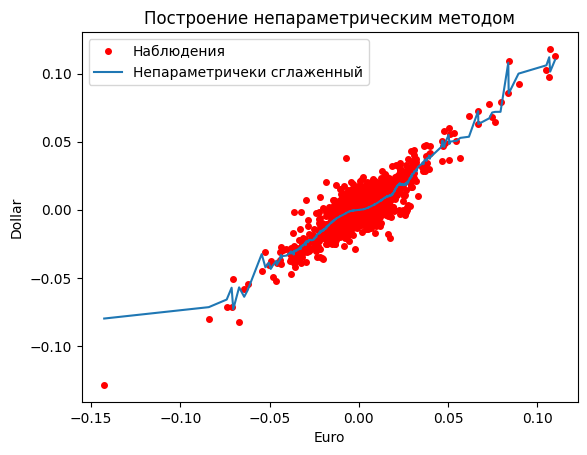

In [78]:
plt.title('Построение непараметрическим методом')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(data['curs_euro'], data['curs_dollar'], 'ro', markersize=4)
plt.plot(np_data_euro, g_calculation(np_differences, optimal_h))
plt.legend(['Наблюдения', 'Непараметричеки сглаженный'])
plt.show()